<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-26 12:57:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2020-11-26 12:57:39 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [6]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB  anaconda
    _py-xgboost-mutex-2.0      |            cpu_0           9 KB  anaconda
    _pytorch_select-0.1        |            cpu_0           2 KB  anaconda
    absl-py-0.10.0             |           py37_0         169 KB  anaconda
    aiohttp-3.6.3              |   py37h7b6447c_0         626 KB  anaconda
    argon2-cffi-20.1.0         |   py37h7b6447c_1         

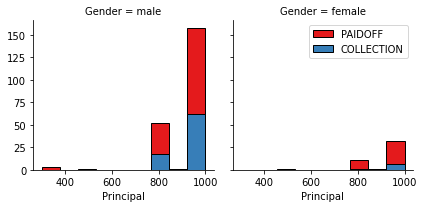

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

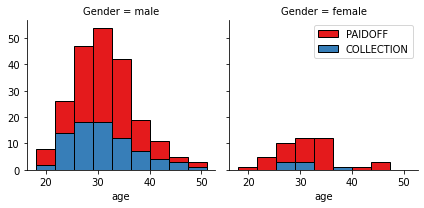

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

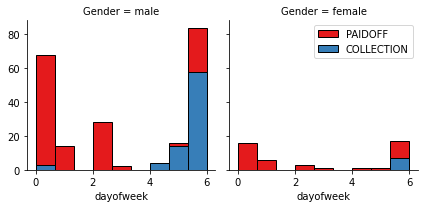

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
# Import library (classifier implementing the k-nearest neighbors)
from sklearn.neighbors import KNeighborsClassifier

# Training
k = 4

# Train Model and Predict
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

In [22]:
# Predicting  (using the model to predict the test set)
yhat_knn = neigh.predict(X_test)
yhat_knn[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [23]:
# Accuracy evaluation 
from sklearn import metrics
print("KNN Train set accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("KNN Test set accuracy: ", metrics.accuracy_score(y_test, yhat_knn))

KNN Train set accuracy:  0.8152173913043478
KNN Test set accuracy:  0.6857142857142857


In [24]:
# Calculate the accuracy of KNN for different Ks
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat_knn2=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn2)
    
    std_acc[n-1]=np.std(yhat_knn2==y_test)/np.sqrt(yhat_knn2.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

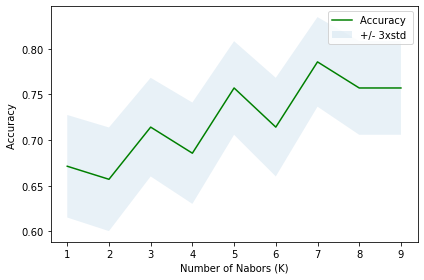

In [25]:
# Plot model accuracy for different number of neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha = 0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [26]:
print("The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7857142857142857 with k= 7


In [27]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_knn2, average='weighted')

0.7468745610338531

In [28]:
# Jaccard Score
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_knn2, pos_label='PAIDOFF')

0.7384615384615385

# "KNN (Load_train) Jaccard Score"

# Decision Tree

In [29]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# Confirm that the dimensions match
print(X_train.shape)
print(y_train.shape)

(242, 8)
(242,)


In [31]:
# Confirm that the dimensions match
print(X_test.shape)
print(y_test.shape)

(104, 8)
(104,)


In [32]:
# Create an instance of the DecisionTreeClassifier called loanTree
# This shows the default parameters
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [33]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [34]:
yhat_tree = loanTree.predict(X_test)

In [35]:
# Print out predTree and y_testset if you want to visually compare the prediction to the actual values
print (yhat_tree[0:5])
print (y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']


In [38]:
# Evaluation - import metrics from sklearn and check the accuracy of our model
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [39]:
print ("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_tree))

DecisionTrees's Accuracy:  0.6538461538461539


In [40]:
# Predict accuracy without sklearn
accuracy = np.sum(y_test == yhat_tree)/(yhat_tree.shape[0])
accuracy

0.6538461538461539

In [41]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_tree, average='weighted')

0.6666949930317142

In [46]:
# Jaccard Score
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_tree, pos_label='PAIDOFF')

0.6043956043956044

[Text(146.475, 195.696, 'X[4] <= -0.188\nentropy = 0.801\nsamples = 242\nvalue = [59, 183]'),
 Text(62.775000000000006, 152.208, 'X[7] <= 0.14\nentropy = 0.139\nsamples = 102\nvalue = [2, 100]'),
 Text(41.85, 108.72, 'entropy = 0.0\nsamples = 60\nvalue = [0, 60]'),
 Text(83.7, 108.72, 'X[2] <= 1.254\nentropy = 0.276\nsamples = 42\nvalue = [2, 40]'),
 Text(41.85, 65.232, 'X[2] <= -0.736\nentropy = 0.179\nsamples = 37\nvalue = [1, 36]'),
 Text(20.925, 21.744, 'entropy = 0.503\nsamples = 9\nvalue = [1, 8]'),
 Text(62.775000000000006, 21.744, 'entropy = 0.0\nsamples = 28\nvalue = [0, 28]'),
 Text(125.55000000000001, 65.232, 'X[2] <= 1.42\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]'),
 Text(104.625, 21.744, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(146.475, 21.744, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(230.175, 152.208, 'X[1] <= -1.46\nentropy = 0.975\nsamples = 140\nvalue = [57, 83]'),
 Text(209.25, 108.72, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(25

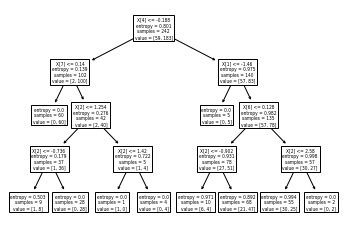

In [42]:
# Visualisation
from sklearn import tree
tree.plot_tree(loanTree)

# Support Vector Machine

In [43]:
import pylab as pl
import scipy.optimize as opt
from sklearn import svm

In [44]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [45]:
yhat_svm = clf.predict(X_test)
yhat_svm[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype ('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix,without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.44      0.30      0.36        27
     PAIDOFF       0.78      0.87      0.82        77

    accuracy                           0.72       104
   macro avg       0.61      0.58      0.59       104
weighted avg       0.69      0.72      0.70       104

Confusion matrix,without normalization
[[ 8 19]
 [10 67]]


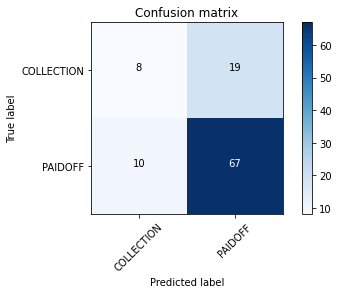

In [48]:
# Compute confusion matrix
yhat_svm = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, yhat_svm,labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_svm))

# Plot non-normalize confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False, title='Confusion matrix')

In [49]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_svm, average='weighted')

0.700967437470505

In [57]:
# Jaccard Score
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_svm, pos_label='PAIDOFF')

0.6979166666666666

# Logistic Regression

In [50]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('Train_set:', X_train.shape, y_train.shape)
print('Train_set:', X_test.shape, y_test.shape)

Train_set: (276, 8) (276,)
Train_set: (70, 8) (70,)


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [53]:
yhat_LR = LR.predict(X_test)
yhat_LR[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [54]:
yhat_probLR = LR.predict_proba(X_test)
yhat_probLR[0:5]

array([[0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.32, 0.68]])

In [55]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape [0]), range (cm.shape [1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm [i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat_LR, labels=['COLLECTION','PAIDOFF']))

[[ 2 13]
 [ 9 46]]


              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70

Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


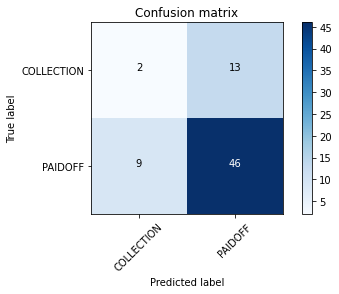

In [56]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_LR, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_LR))

                              
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False, title='Confusion matrix')

In [57]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_LR, average='weighted')

0.6670522459996144

In [68]:
# Using Jaccard Index to Evaluate Accuracy
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_LR, pos_label='PAIDOFF')

0.6764705882352942

In [58]:
# Log Loss
from sklearn.metrics import log_loss
log_loss(y_test, yhat_probLR)

0.5772287609479654

In [59]:
# Accuracy
from sklearn.metrics import accuracy_score
print ("Accuracy: ", metrics.accuracy_score(y_test, yhat_LR))

Accuracy:  0.6857142857142857


# Model Evaluation using Test set

In [60]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [61]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-11-26 13:38:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-11-26 13:38:31 (38.5 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [62]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [63]:
test_df.shape

(54, 10)

In [64]:
# Convert to date time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


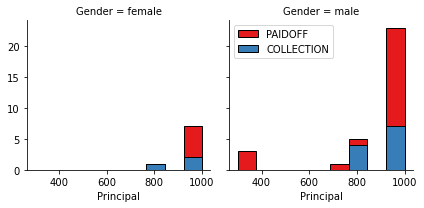

In [65]:
import seaborn as sns

bins = np.linspace(test_df.Principal.min(), test_df.Principal.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes [-1].legend()
plt.show()

### Data visualization and pre-processing

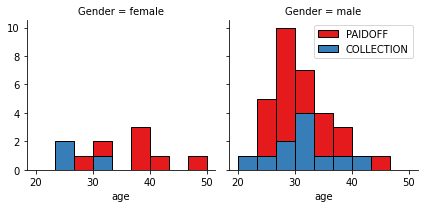

In [66]:
bins = np.linspace(test_df.age.min(), test_df.age.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Pre-processing: Feature selection/extraction

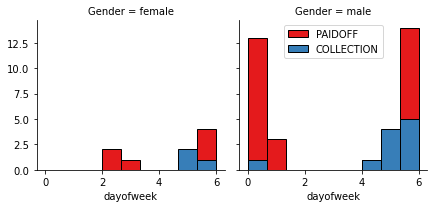

In [67]:
# Day of the week loans are processed
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [68]:
# Payment of loans takes place more at the beginning of the week.
# Set threshold value for end of week

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [69]:
# Convert categorical features to numerical values
# Gender
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

In [70]:
# Convert male to 0 and female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [71]:
# Convert categorical features to numerical values
# Education
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [72]:
# Feature before one hot encoding
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [73]:
# Using one hot encoding to convert categorical variables and append them to the feature dataframe
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [74]:
X2 = Feature_test
X2[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [75]:
X2.shape

(54, 8)

In [76]:
y2 = test_df['loan_status'].values
y2[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [77]:
y2.shape

(54,)

### Normalize data

In [78]:
X2 = preprocessing.StandardScaler().fit(X2).transform(X2)
X2[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [79]:
X2.shape

(54, 8)

In [80]:
y2.shape

(54,)

## KNN

In [81]:
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split( X2, y2, test_size=0.2, random_state=4)
print ('Train set: ', X2_train.shape, y2_train.shape)
print ('Test set:', X2_test.shape, y2_test.shape)

Train set:  (43, 8) (43,)
Test set: (11, 8) (11,)


In [82]:
# Import library (classifier implementing the k-nearest neighbor
from sklearn.neighbors import KNeighborsClassifier

# Training
k = 4

# Train Model and Predict
neighKNN2 = KNeighborsClassifier(n_neighbors = k).fit(X2_train,y2_train)
neighKNN2

KNeighborsClassifier(n_neighbors=4)

In [83]:
# Predicting  (using the model to predict the test set)
yhatKNN2 = neighKNN2.predict(X2_test)
yhatKNN2[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [84]:
from sklearn import metrics
print("Train set accuracy: ", metrics.accuracy_score(y2_train, neighKNN2.predict(X2_train)))
print("Test set accuracy: ", metrics.accuracy_score(y2_test, yhatKNN2))

Train set accuracy:  0.8372093023255814
Test set accuracy:  0.6363636363636364


In [85]:
# Calculate the accuracy of KNN for different Ks
Ks = 10
mean_acc2 = np.zeros((Ks-1))
std_acc2 = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict
    neighKNN2 = KNeighborsClassifier(n_neighbors = n).fit(X2_train, y2_train)
    yhatKNN2=neighKNN2.predict(X2_test)
    mean_acc2[n-1] = metrics.accuracy_score(y2_test, yhatKNN2)
    
    std_acc2[n-1]=np.std(yhatKNN2==y2_test)/np.sqrt(yhatKNN2.shape[0])

mean_acc2

array([0.73, 0.64, 0.82, 0.64, 0.82, 0.55, 0.82, 0.73, 0.82])

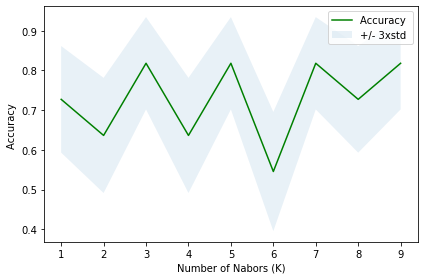

In [86]:
# Plot model accuracy for different number of neighbors
plt.plot(range(1,Ks),mean_acc2,'g')
plt.fill_between(range(1,Ks), mean_acc2 - 1 * std_acc2, mean_acc2 + 1 * std_acc2, alpha = 0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [87]:
print("The best accuracy was", mean_acc2.max(), "with k=", mean_acc2.argmax()+1)

The best accuracy was 0.8181818181818182 with k= 3


In [88]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y2_test, yhatKNN2, average='weighted')

0.8181818181818182

In [89]:
# Jaccard Score
from sklearn.metrics import jaccard_score
jaccard_score(y2_test, yhatKNN2, pos_label='PAIDOFF')

0.8181818181818182

## Decision Tree

In [90]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [91]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=3)

In [92]:
# Confirm that the dimensions match
print(X2_train.shape)
print(y2_train.shape)

(37, 8)
(37,)


In [93]:
# Confirm that the dimensions match
print(X2_test.shape)
print(y2_test.shape)

(17, 8)
(17,)


In [94]:
# Create an instance of the DecisionTreeClassifier called loanTree2
# This shows the default parameters
loanTree2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree2

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [95]:
loanTree2.fit(X2_train,y2_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [96]:
yhat_tree2 = loanTree2.predict(X2_test)

# Print out predTree and y_testset if you want to visually compare the prediction to the actual values
print (yhat_tree2[0:5])
print (y2_test[0:5])

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']


In [97]:
# Evaluation - import metrics from sklearn and check the accuracy of our model
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [98]:
print ("DecisionTrees's Accuracy: ", metrics.accuracy_score(y2_test, yhat_tree2))

DecisionTrees's Accuracy:  0.5294117647058824


In [99]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y2_test, yhat_tree2, average='weighted')

0.5294117647058824

In [100]:
# Jaccard Score
from sklearn.metrics import jaccard_score
jaccard_score(y2_test, yhat_tree2, pos_label='PAIDOFF')

0.5294117647058824

In [101]:
# Predict accuracy without sklearn
accuracyTree2 = np.sum(y2_test == yhat_tree2)/(yhat_tree2.shape[0])
accuracyTree2

0.5294117647058824

[Text(83.7, 195.696, 'X[4] <= -0.268\nentropy = 0.842\nsamples = 37\nvalue = [10, 27]'),
 Text(41.85, 152.208, 'entropy = 0.0\nsamples = 12\nvalue = [0, 12]'),
 Text(125.55000000000001, 152.208, 'X[1] <= -1.246\nentropy = 0.971\nsamples = 25\nvalue = [10, 15]'),
 Text(83.7, 108.72, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(167.4, 108.72, 'X[2] <= -0.056\nentropy = 1.0\nsamples = 20\nvalue = [10, 10]'),
 Text(83.7, 65.232, 'X[7] <= 0.15\nentropy = 0.918\nsamples = 12\nvalue = [8, 4]'),
 Text(41.85, 21.744, 'entropy = 0.65\nsamples = 6\nvalue = [5, 1]'),
 Text(125.55000000000001, 21.744, 'entropy = 1.0\nsamples = 6\nvalue = [3, 3]'),
 Text(251.10000000000002, 65.232, 'X[3] <= 0.736\nentropy = 0.811\nsamples = 8\nvalue = [2, 6]'),
 Text(209.25, 21.744, 'entropy = 0.918\nsamples = 6\nvalue = [2, 4]'),
 Text(292.95, 21.744, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]')]

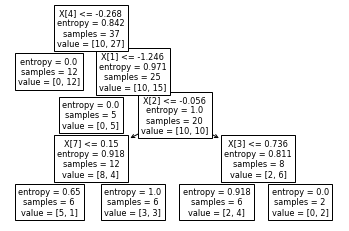

In [102]:
# Visualisation
from sklearn import tree
tree.plot_tree(loanTree2)

## Support Vector Machine

In [103]:
import pylab as pl
import scipy.optimize as opt
from sklearn import svm

In [104]:
clf2 = svm.SVC(kernel='rbf')
clf2.fit(X2_train, y2_train)

SVC()

In [105]:
yhat_svm2 = clf2.predict(X2_test)
yhat_svm2[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [107]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype ('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix,without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00         4
     PAIDOFF       0.76      1.00      0.87        13

    accuracy                           0.76        17
   macro avg       0.38      0.50      0.43        17
weighted avg       0.58      0.76      0.66        17

Confusion matrix,without normalization
[[ 0  4]
 [ 0 13]]


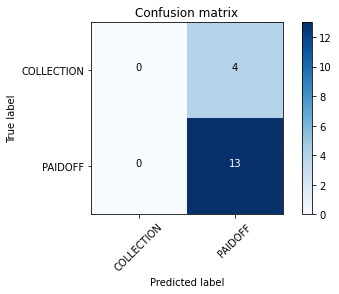

In [108]:
# Compute confusion matrix
yhat_svm2 = clf2.predict(X2_test)
cnf_matrix2 = confusion_matrix(y2_test, yhat_svm2, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)

print(classification_report(y2_test, yhat_svm2))

# Plot non-normalize confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['COLLECTION', 'PAIDOFF'], normalize= False, title='Confusion matrix')

In [109]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y2_test, yhat_svm2, average='weighted')

0.6627450980392157

In [110]:
# Jaccard Score
from sklearn.metrics import jaccard_score
jaccard_score(y2_test, yhat_svm2, pos_label='PAIDOFF')

0.7647058823529411

## Logistic Regression

In [111]:
from sklearn import preprocessing
X2 = preprocessing.StandardScaler().fit(X2).transform(X2)
X2[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [112]:
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=4)
print('Train_set:', X2_train.shape, y2_train.shape)
print('Train_set:', X2_test.shape, y2_test.shape) 

Train_set: (43, 8) (43,)
Train_set: (11, 8) (11,)


In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR2 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
LR2

LogisticRegression(C=0.01, solver='liblinear')

In [114]:
yhat_LR2 = LR2.predict(X2_test)
yhat_LR2[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [115]:
yhat_probLR2 = LR2.predict_proba(X2_test)
yhat_probLR2[0:5]

array([[0.46, 0.54],
       [0.5 , 0.5 ],
       [0.45, 0.55],
       [0.25, 0.75],
       [0.49, 0.51]])

In [116]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape [0]), range (cm.shape [1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm [i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y2_test, yhat_LR2, labels=['COLLECTION','PAIDOFF']))

[[ 0  1]
 [ 0 10]]


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00         1
     PAIDOFF       0.91      1.00      0.95        10

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11

Confusion matrix, without normalization
[[ 0  1]
 [ 0 10]]


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


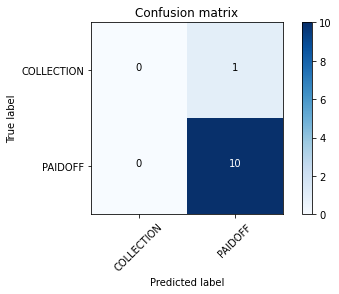

In [117]:
# Compute confusion matrix
cnf_matrix2 = confusion_matrix(y2_test, yhat_LR2, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)

print(classification_report(y2_test, yhat_LR2))

                              
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=['COLLECTION','PAIDOFF'],normalize= False, title='Confusion matrix')

In [118]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y2_test, yhat_LR2, average='weighted')

0.8658008658008658

In [119]:
# Using Jaccard Index to Evaluate Accuracy
from sklearn.metrics import jaccard_score
jaccard_score(y2_test, yhat_LR2, pos_label='PAIDOFF')

0.9090909090909091

In [120]:
# Log Loss
from sklearn.metrics import log_loss
log_loss(y2_test, yhat_probLR2)

0.5437643528102666

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.8182  | 0.8182   | NA      |
| Decision Tree      | 0.5294  | 0.5294   | NA      |
| SVM                | 0.9091  | 0.8658   | NA      |
| LogisticRegression | 0.9091  | 0.8658   | 0.5438  |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>